# Import lots of stuff

In [98]:
import pandas as pd
import pylab as pyl
import nltk as nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize
import re
#enable longer display
pd.set_option('display.max_rows', 500)

# Preprocess data

## Import annotated file

In [99]:
d_raw = pd.read_csv('../../data/tangrams/old/oldTangrams.csv')

# Drop time column
d = (d_raw
    .copy()
    .drop('time', 1)
    .query('tangram != "0"')
    .query('tangram != "*"'))


## Tokenize

In [100]:
d['tokens'] = [[word for word in nltk.word_tokenize(sentence.lower()) if word.isalpha()]
               for sentence in d['contents']]

## Get number of words used

In [101]:
d['numWords'] = [pd.value_counts(words).sum() for words in d['tokens']]

# Result 1: Generate file for POS analysis

## Get part of speech

In [102]:
d['pos'] = [[pos for (key, pos) in nltk.pos_tag(rowTokens, tagset = 'universal')] for rowTokens in d['tokens']]

## Get list of all unique POS labels

In [103]:
posSet = set({})
for row in d['pos'] :
    for pos in row :
        posSet.add(pos)

## Get counts for each POS label

In [104]:
for pos in posSet :
    colName = pos + "num"
    d[colName] = [posList.count(pos) for posList in d['pos']]

## Export to csv for plotting in R

In [105]:
d.drop(["pos", "contents", "tokens"], 1).to_csv("posTagged.csv", index = False)

# Result 2: Calculate indicator words for tangrams/rounds

In [59]:
def getWordCounts(df, gameid, roundNum, tangram = None) :
    roundCond = 'roundNum == ' + roundNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'tangram == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow['tokens'].tolist() 
                    for item in sublist])

#creates mini dataframe that grabs the words used in round n for a given tangram and gameid
def selectTangramRoundWords(tangram, roundNum, gameid):
    wordCounts = getWordCounts(test2, gameid, roundNum, tangram)
    tokenList = pd.DataFrame(wordCounts.items(), 
                             columns=['word', 'count'])
    return tokenList['word'].tolist()

In [60]:
import itertools
from collections import Counter
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#https://en.wikipedia.org/wiki/Pointwise_mutual_information

#returns a table with the all words about 0 PMI and their counts for a given tangram
#calculate the probability for words given tangram A ------ p(x|y)

# Note that we're reconstructing totalCounts for every tangram... 
def makeMyPMI(tangram, roundNum, gameid):

    # count words w/in tangram
    tangramCounts = getWordCounts(test2, gameid, roundNum, tangram)
    totalCounts = getWordCounts(test2, gameid, roundNum)

    #total number of words 
    tangramNumWords = (1 if sum(tangramCounts.values()) == 0 
                       else sum(tangramCounts.values()))
    totalNumWords = float(sum(totalCounts.values()))

    #dataframe to compare 
    indicatorDF = pd.merge(pd.DataFrame(tangramCounts.items(), columns=['word', 'count']),
                           pd.DataFrame(totalCounts.items(), columns=['word', 'totalCount']),
                           on='word', how = 'inner')

    # The equation is like this: log((P(word|A)/P(word))). 
    # The P(word) is looking at the global likelihood of that word being used
    # among all the tangrams

    #calculate PMI without log first. Having trouble with float issues. 
    indicatorDF['roughPMI'] = ((indicatorDF['count']/tangramNumWords)
                                / (indicatorDF['totalCount']/totalNumWords))
    indicatorDF['logPMI'] = [math.log10(num) for num in indicatorDF['roughPMI']]
    
    #indicatorAdf
    highPMI = indicatorDF[indicatorDF['logPMI'] > -1]
    highPMI = highPMI.sort(['logPMI'], ascending=0)
    
    #insert tangram and roundNum and gameid
    highPMI['gameid'] = gameid
    highPMI['tangram'] = tangram
    highPMI['roundNum'] = roundNum
    
    #rearragne columns
    cols = highPMI.columns.tolist()
    cols = cols[-3:] + cols[:-3]
    highPMI = highPMI[cols]
    
    #remove column rough PMI
    highPMI = highPMI.drop('roughPMI', 1)
    
    return highPMI

In [61]:
#grab words with highestPMI
def highestPMI(tangram, roundNum, gameid):
    PMIdf = makeMyPMI(tangram, roundNum, gameid)
    #if PMIdf has words, pull out max values, it is empty return it as is
    if len(PMIdf.index) > 0:
        PMI_values = PMIdf.logPMI.unique()
        maxPMI = PMI_values.max()
        PMIdf = PMIdf.loc[PMIdf['logPMI'] == maxPMI]
        #just return word column
        PMIdf = PMIdf[['word']]
        return PMIdf
    #if PMIdf is empty, return it as is
    else: 
        return PMIdf

#function to randomly sample a word from the list of words used by a group for a given tangram on round 1
def randomWord(wordDataframe):
    if len(wordDataframe.index) == 0:
        return wordDataframe
    else: 
        rows = np.random.choice(wordDataframe.index.values, 1)
        randomSample = wordDataframe.ix[rows]
        return randomSample

#create dataframe of words used in round 6 and the words that had the highest pmi in round 1
def mergePmiRounds(tangram, gameid):
    round1 = highestPMI(tangram, 1, gameid)
    round6 = selectTangramRoundWords(tangram, 6, gameid)
    innerMerge = pd.merge(round1, round6, on = 'word', how='inner')
    return innerMerge

# measures if the words in round 6 had a highPMI in round 1. If they do, return a 1. If not, return 0. 
def continuityCount(innerMerge):
    continuityCount = 0 
    if len(innerMerge.index) > 0:
        continuityCount += 1
    else:
        continuityCount = 0
    return continuityCount

#takes in a string and turns it into a list
def listify(word):
    l = []
    l.append(word)
    return l

#given a pos tag like this: [('person', 'NN')], determine if the word is a noun
def isWordNoun(posTag):
    if posTag[0][1] == 'NN':
        return True
    else:
        return False

#function which only keeps nouns in dataframe word column
def filterForNoun(df):
    df['token'] = [listify(word) for word in df['word']]
    df['pos'] = [nltk.pos_tag(token) for token in df['token']]
    df['noun'] = [isWordNoun(postag) for postag in df['pos']]
    df = df[df.noun == True]
    df = df[['word']]
    return df


def PMImatches(highPMI_df, round6_df):
    if len(highPMI_df.index) == 0:
        return 0
    else:
        highPMI_wordList = highPMI_df['word'].tolist()
        length = len(highPMI_wordList)
        round6_wordList = round6_df['word'].tolist()
        count = 0
        for i in range(length):
            if highPMI_wordList[i] in round6_wordList:
                count += 1
            else:
                count += 0
        return float(count)/length
    
def nullmatches(round1_df, round6_df):
    if len(round1_df.index) == 0:
        return 0
    else:
        random_round1_df = randomWord(round1_df)
        random_round1_list = random_round1_df['word'].tolist()
        round6_list = round6_df['word'].tolist()
        count = 0
        if random_round1_list[0] in round6_list:
             return 1
        else:
            return 0
    

#gamids
gameidList = pd.unique(test1.gameid.ravel()).tolist()
# ['0215-4', '0619-a', '1903-d', '2121-8', '2388-c', '2878-d',
#        '3409-e', '3423-d', '3682-d', '3891-4', '4060-2', '4404-5',
#        '4800-3', '6510-9', '7764-f', '9440-7', '0770-e', '1490-f',
#        '2760-0', '4927-0', '5204-4', '7264-8', '8762-d', '9409-4']
#tangrams
tangramList = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


#picks a highest PMI word from round 1 (for tangram/gameid) and sees if it is used in round 6. Calculates proportion of this over 288 tangram/gameid situations
def totalContinuity():
    totalContinuity = 0
    for gameid in gameidList:    
        for tangram in tangramList:
            highPMIwordList = highestPMI(tangram, 1, gameid)
            #random_highPMIWord = randomWord(highPMIwordList)
            round6WordList = selectTangramRoundWords(tangram, 6, gameid)
            score = PMImatches(highPMIwordList, round6WordList)
            totalContinuity = totalContinuity + score
    return float(totalContinuity)/288


#totalContinuity()

#picks a random noun from round 1 (for tangram/gameid) and sees if it is used in round 6. Calculates proportion, given that is does this 288 times
def nullDistribution():
    totalContinuity = 0
    for gameid in gameidList:    
        for tangram in tangramList:
            round1tangramWordList = selectTangramRoundWords(tangram, "1", gameid)
#             nounOnlyWordList = filterForNoun(round1tangramWordList)
#             random_round1Word = randomWord(nounOnlyWordList)
#             random_round1Word = randomWord(round1tangramWordList)
            round6WordList = selectTangramRoundWords(tangram, "6", gameid)
            score = nullmatches(round1tangramWordList, round6WordList) 
            totalContinuity = totalContinuity +  score
    return float(totalContinuity)/288



    
# tester = selectTangramRoundWords('A', 1, '0215-4')
# tester = filterForNoun(tester)
# tester

PMI_distribution = []
def longDistribution():
    for i in range(100):
        proportion = nullDistribution() 
        PMI_distribution.append(proportion)
    return PMI_distribution

# PMI_distribution_lists = [0.4305555555555556, 0.4513888888888889]
# null_distribution_lists = [0.2847222222222222, 0.2708333333333333]
# null_noun_distribution_lists = [0.3611111111111111]
#nullDistribution()
#totalContinuity()



    
# round1Test = highestPMI('E', 1, '0215-4')
# round6Test = selectTangramRoundWords('E', 6, '0215-4')
# nullmatches(round1Test, round6Test)


# 'pup' in [ 'dog', 'kitten']
# randomPMI['word'].tolist()[0] in round6Test['word'].tolist()
# round6Test['word'].tolist()
    
# PMImatches(round1Test, round6Test)
# highPMITest
# round6Test
# nullDistribution()
# nullDistributionLongList = longDistribution()



#longDistribution()


In [98]:
import csv
#picks a random noun from round 1 (for tangram/gameid) and sees if it is used in round 6. Calculates proportion, given that is does this 288 times
def selectWordsInRound1(n) :
    df = test2.copy()
    #unlist tokens so that each row has a word in it
    df_round1 = df[df['roundNum'] == 1]
    tokenList = df_round1['tokens'].tolist()
    tokenList = [item for sublist in tokenList for item in sublist]
    #get dictionary counter for words used for tangram A
    tokenList = Counter(tokenList)
    #turn the word list into a dataframe
    tokenList = pd.DataFrame(tokenList.items(), columns=['word', 'count'])
    denseTokenList = tokenList[tokenList['count'] > n]
    #remove count column
    return denseTokenList['word'].tolist()

wordList = selectWordsInRound1(1)

with open('matchAndPMI.csv', 'ab') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['word', 'match', 'pmi', 'total'])
    for word in wordList :
        print(word)
        pmi = 0
        match = 0
        total = 0
        for gameid in gameidList:    
            for tangram in tangramList:
                round1WordList = selectTangramRoundWords(tangram, "1", gameid)
                total = total + 1 if word in round1WordList else total
                round6WordList = selectTangramRoundWords(tangram, "6", gameid)
                match = match + 1 if word in round1WordList and word in round6WordList else match
                if word in round1WordList :
                    PMI_df = makeMyPMI(tangram, "1", gameid)
                    pmi = pmi + PMI_df[PMI_df['word'] == word]['logPMI'].tolist()[0]
        writer.writerow([word, float(match) / float(total), pmi/total, total])


all


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


pointing
hanging
dish
to
tail
asking
under
sorry
sitting
very
balancing
laying
large
small
guy
runway
fence
go
second
air
what
goes
falling
bird
body
leg
here
let
alone
teacher
wait
box
k
bow
weird
makes
sticking
extra
standing
from
would
distinct
dude
arms
next
more
sort
flat
diamond
flag
carrying
rabbit
me
this
getting
can
bent
figure
plate
awesome
really
something
keep
dress
mouse
instead
okay
spot
floor
coming
horizontal
man
a
neck
third
maybe
roundish
so
wing
pointed
looks
its
bunch
limbs
into
pushup
then
them
someone
skater
they
hands
not
now
bigger
l
each
tray
side
square
tilted
doing
yeah
our
girl
out
looking
got
model
boobs
completely
thrown
backwards
yup
could
thing
think
first
there
number
one
feet
done
long
another
little
lego
top
their
too
legs
that
part
butt
than
kind
perfectly
tree
toward
descriptions
and
angel
sad
have
curved
any
angle
dancing
other
which
towards
opposite
extending
face
points
pointy
snowman
ground
front
should
only
robe
over
wearing
his
triangle
above


In [7]:


nullDistributionNums = [0.2013888888888889,
 0.19444444444444445,
 0.1423611111111111,
 0.1597222222222222,
 0.13541666666666666,
 0.1527777777777778,
 0.13194444444444445,
 0.17708333333333334,
 0.1388888888888889,
 0.1597222222222222,
 0.1597222222222222,
 0.16666666666666666,
 0.1423611111111111,
 0.21180555555555555,
 0.1527777777777778,
 0.16319444444444445,
 0.1840277777777778,
 0.1423611111111111,
 0.18055555555555555,
 0.15625,
 0.17708333333333334,
 0.1701388888888889,
 0.19444444444444445,
 0.1701388888888889,
 0.16666666666666666,
 0.1701388888888889,
 0.1597222222222222,
 0.1527777777777778,
 0.14930555555555555,
 0.1388888888888889,
 0.2048611111111111,
 0.16666666666666666,
 0.14583333333333334,
 0.1736111111111111,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.15625,
 0.1388888888888889,
 0.1423611111111111,
 0.1527777777777778,
 0.1597222222222222,
 0.2048611111111111,
 0.15625,
 0.15625,
 0.1597222222222222,
 0.1597222222222222,
 0.13541666666666666,
 0.1527777777777778,
 0.16319444444444445,
 0.16666666666666666,
 0.1423611111111111,
 0.16666666666666666,
 0.1736111111111111,
 0.1388888888888889,
 0.18055555555555555,
 0.14930555555555555,
 0.15625,
 0.1701388888888889,
 0.14583333333333334,
 0.15625,
 0.18055555555555555,
 0.1597222222222222,
 0.1597222222222222,
 0.17708333333333334,
 0.13541666666666666,
 0.14583333333333334,
 0.1284722222222222,
 0.1527777777777778,
 0.2048611111111111, 
 0.1527777777777778,
 0.1527777777777778,
 0.1527777777777778,
 0.1423611111111111,
 0.1597222222222222,
 0.1388888888888889,
 0.1701388888888889,
 0.1597222222222222,
 0.1597222222222222,
 0.17708333333333334,
 0.16319444444444445,
 0.14930555555555555,
 0.1597222222222222,
 0.1527777777777778,
 0.14930555555555555,
 0.1423611111111111,
 0.15625,
 0.1736111111111111,
 0.1597222222222222,
 0.1701388888888889,
 0.1527777777777778,
 0.1423611111111111,
 0.15625,
 0.1388888888888889,
 0.19791666666666666,
 0.14583333333333334,
 0.17708333333333334,
 0.1388888888888889,
 0.1909722222222222,
 0.14583333333333334,
 0.1875,
 0.16666666666666666,
 0.19444444444444445,
 0.16319444444444445,
 0.15625,
 0.1527777777777778,
 0.1701388888888889,
 0.12152777777777778,
 0.1701388888888889,
 0.13194444444444445,
 0.1597222222222222,
 0.1388888888888889,
 0.1736111111111111,
 0.1527777777777778,
 0.14930555555555555,
 0.16319444444444445,
 0.1527777777777778,
 0.14583333333333334,
 0.13541666666666666,
 0.1875,
 0.1597222222222222,
 0.16666666666666666,
 0.1909722222222222,
 0.1597222222222222,
 0.16319444444444445,
 0.14930555555555555,
 0.1909722222222222,
 0.1527777777777778,
 0.14930555555555555,
 0.1527777777777778,
 0.1736111111111111,
 0.18055555555555555,
 0.1423611111111111,
 0.15625,
 0.1840277777777778,
 0.1388888888888889,
 0.16319444444444445,
 0.14930555555555555,
 0.16319444444444445,
 0.16319444444444445,
 0.1840277777777778,
 0.19791666666666666,
 0.1597222222222222,
 0.1388888888888889,
 0.1736111111111111,
 0.1423611111111111,
 0.13541666666666666,
 0.15625,
 0.1875,
 0.1597222222222222,
 0.16319444444444445,
 0.1597222222222222,
 0.1423611111111111,
 0.1597222222222222,
 0.1875,
 0.13194444444444445,
 0.16319444444444445,
 0.1423611111111111,
 0.16666666666666666,
 0.1388888888888889,
 0.14930555555555555,
 0.1527777777777778,
 0.16319444444444445,
 0.1423611111111111,
 0.1701388888888889,
 0.1388888888888889,
 0.15625,
 0.17708333333333334,
 0.19444444444444445,
 0.1736111111111111,
 0.1701388888888889,
 0.14583333333333334,
 0.16319444444444445,
 0.17708333333333334,
 0.14583333333333334,
 0.1875,
 0.16666666666666666,
 0.17708333333333334,
 0.16666666666666666,
 0.1527777777777778,
 0.1736111111111111,
 0.16666666666666666,
 0.11805555555555555,
 0.18055555555555555,
 0.16666666666666666,
 0.1701388888888889,
 0.1388888888888889,
 0.16666666666666666,
 0.14930555555555555,
 0.1909722222222222,
 0.17708333333333334,
 0.125,
 0.15625,
 0.1701388888888889,
 0.14930555555555555,
 0.11805555555555555,
 0.1597222222222222,
 0.14583333333333334,
 0.16666666666666666,
 0.16319444444444445]


#nullDistributionNums.to_csv("nullDistributionNums.csv")  
plt.hist(nullDistributionNums)

ImportError: No module named scipy

#Find confidence interval

In [10]:

from scipy import stats
import numpy as np
# import scipy as sp
# import scipy.stats

def mean_confidence_interval(nullDistributionNums, confidence=0.95):
    a = 1.0*np.array(nullDistributionNums)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

ImportError: No module named scipy

In [18]:
df1 = pd.DataFrame
df1 = df1({'test_set': nullDistributionNums})
df1

df1.to_csv("nullDistributionNums.csv") 

'under'

#Filtering for nouns 

#Creat dictionary that contains tangram, roundNum, word, and frequency

In [12]:
dfForDict = test2.copy()
dfForDict = dfForDict[20:500]

#http://stackoverflow.com/questions/16333296/how-do-you-create-nested-dict-in-python
#set up the nested dictionaries
tangramDict = {}
tangramDict['tangram'] = {}
tangramDict['tangram']['roundNum'] = {}
tangramDict['tangram']['roundNum']['word'] = 'count'
tangramDict

#populate the dictionary 

#http://stackoverflow.com/questions/635483/what-is-the-best-way-to-implement-nested-dictionaries-in-python


dfForDict = dfForDict[['roundNum', 'tangram', 'tokens']]
dfForDict = dfForDict.sort(['roundNum', 'tangram'], ascending = [True, True])
#rearrange columns
cols = dfForDict.columns.tolist()
cols = ['tangram', 'roundNum', 'tokens']
dfForDict = dfForDict[cols]
#dfForDict = dfForDict.groupby('roundNum')
# dfForDict = dfForDict[2:500]


import pprint

class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value
    
d = Vividict()

# d['foo']['bar']
# d['foo']['baz']
# d['fizz']['buzz']
# d['primary']['secondary']['tertiary']['quaternary']



pprint.pprint(d)

#http://stackoverflow.com/questions/18695605/python-pandas-dataframe-to-dictionary

#{g: f['contents'].tolist() for f,g in dfForDict.groupby("tangram") for k,g in dfForDict.groupby("roundNum")}

#{k: g["value"].tolist() for k,g in ptest.groupby("id")}


def retro_dictify(frame):
    d = {}
    for row in frame.values:
        here = d
        for elem in row[:-2]:
            if elem not in here:
                here[elem] = {}
            here = here[elem]
        here[row[-2]] = row[-1]
    return d

retro_dictify(dfForDict)



# d = defaultdict(int)
# for word in bigWordList :
#   for tangram in tangrams :
#     for roundNum in roundNums :
#       d[tangram + ‘,’ + str(roundNum) + ‘,’ + word] += 
#countOccurences(word, tangram, roundNum)

# writer = csv.writer(open(’tangramWordCounts.csv', 'wb'))
# for key, value in d.items():
#   writer.writerow([key, value])

#dfForDict.groupby()

#[f(x) for x in list]

dfForDict

{}


,tangram,roundNum,tokens
167,A,1,"[the, dancing, chicken, goes, facing, left, go..."
169,A,1,"[looks, like, a, fish, with, a, block, on, it,..."
183,A,1,"[there, one, that, looks, like, a, bird, facin..."
465,A,1,"[and, is, or, a, rabbit]"
466,A,1,"[is, the, one, kicking]"
572,A,1,"[start, with, your, and, let, me, know, what, ..."
573,A,1,"[a, guy, with, a, foot, up, carrying, a, flag]"
574,A,1,"[got, it]"
174,B,1,"[the, one, that, looks, like, an, angel, kneel..."
176,B,1,"[also, looks, like, a, terrier, with, a, block..."


In [14]:
#use highPMI list to filter words for tangrams over the next rounds
#need list of words and their frequency for each round
#need 6 dictionaries/frequencies merged by the highPMI words

#the dataframe with all tangrams and all rounds
bigFrame = test2.copy()
#bigFrameTangram = bigFrame[bigFrame.tangram == 'A']

#cumWordsAndCounts = highPMI

def createFrequencyTable(roundNum, tangram):
    #filter for the tangram desired
    bigFrameTangram = bigFrame[bigFrame.tangram == tangram]
    bigFrameTangram = bigFrame[bigFrame.roundNum == roundNum]
    cumWordsAndCounts = makeMyPMI(tangram)
    #print cumWordsAndCounts
    #go from 2-6 because round1 is included with cumWordsAndCounts 
    #for roundNum in [2,3,4,5,6]:
    #filter by roundNum
    bigFrameTangram = bigFrameTangram[bigFrameTangram.roundNum == roundNum]

    #bigDictionary turns all of the tokens used to talk about tangram A over round into a dictionary
    smallDictionary = bigFrameTangram['tokens'].tolist()
    smallDictionary = [item for sublist in smallDictionary for item in sublist]
    #get dictionary counter for words used for tangram A
    smallDictionary = Counter(smallDictionary)

    #convert to normal dictionary in order to pull out counts more easily
    #smallDictionary = smallDictionary.items() 

    #turn dictionary with counts into dataframe
    #dataframe to look at words and their counts for tangram A in round 1
    smallWordsAndCounts = pd.DataFrame(smallDictionary.items(), columns=['word', 'count'])
    #smallWordsAndCount['tangram'] = tan
    #dataframe which will contain words and the frequencies of them on rounds 1 through 6
    #print cumWordsAndCounts[:5][:5]
    #cumWordsAndCounts = pd.concat([cumWordsAndCounts, smallWordsAndCounts])
    #print cumWordsAndCounts[:5][:5]

    #reset bigFrame so we can go to the next roundNum
    #bigFrameTangram = bigFrame[bigFrame.tangram == tangram]

    return smallWordsAndCounts
    

wordFrequency_A = createFrequencyTable(2, 'A')

wordFrequency_A

# d = defaultdict(int)
# for word in bigWordList :
#   for tangram in tangrams :
#     for roundNum in roundNums :
#       d[tangram + ‘,’ + str(roundNum) + ‘,’ + word] += countOccurences(word, tangram, roundNum)


 
    
    
# allTangramsFreqs = pd.DataFrame()
# for tangram in ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']:
#     #creates the words and frequencies over rounds df for one tangram
#     oneTangramFreq = createFrequencyTable(tangram)
#     #joins all words and their frequencies over rounds for each tangram
#     allTangramsFreqs = pd.concat([allTangramsFreqs, oneTangramFreq], axis=1)

# #change the column names to tangram letter and correct round numbers
# allTangramsFreqs.columns = ['A', '1', '2', '3', '4', '5', '6', 'B', '1', '2', '3', '4', '5', '6', 
#                            'C', '1', '2', '3', '4', '5', '6', 'D', '1', '2', '3', '4', '5', '6', 
#                            'E', '1', '2', '3', '4', '5', '6', 'F', '1', '2', '3', '4', '5', '6', 
#                            'G', '1', '2', '3', '4', '5', '6', 'H', '1', '2', '3', '4', '5', '6', 
#                            'I', '1', '2', '3', '4', '5', '6', 'J', '1', '2', '3', '4', '5', '6',
#                            'K', '1', '2', '3', '4', '5', '6', 'L', '1', '2', '3', '4', '5', '6']
# allTangramsFreqs.to_csv("allTangramsFreqs.csv")   

    

len(pd.unique(test1.gameid.ravel()))


24

#Occurances function

In [132]:
#use highPMI list to filter words for tangrams over the next rounds
#need list of words and their frequency for each round
#need 6 dictionaries/frequencies merged by the highPMI words

#the dataframe with all tangrams and all rounds
bigFrame = test2.copy()

def createFrequencyTable(tangram, roundNum):
    #filter for the tangram desired
    myDictDf = bigFrame[bigFrame.tangram == tangram]
    myDictDf = myDictDf[myDictDf.roundNum == roundNum]

    #bigDictionary turns all of the tokens used to talk about tangram A over round into a dictionary
    smallDictionary = myDictDf['tokens'].tolist()
    smallDictionary = [item for sublist in smallDictionary for item in sublist]
    #get dictionary counter for words used for tangram A
    smallDictionary = Counter(smallDictionary)

    #turn dictionary with counts into dataframe
    #dataframe to look at words and their counts for tangram A in round 1
    smallWordsAndCounts = pd.DataFrame(smallDictionary.items(), columns=['word', 'count'])

    return smallWordsAndCounts
    

createFrequencyTable('A', 3)

d = defaultdict(int)
for word in bigWordList :
  for tangram in tangrams :
    for roundNum in roundNums :
      d[tangram + ‘,’ + str(roundNum) + ‘,’ + word] += countOccurences(word, tangram, roundNum)


 






,word,count
0,walking,1
1,pointing,1
2,looks,1
3,stepping,1
4,yep,2
5,its,1
6,marching,1
7,to,2
8,good,1
9,bear,1


#Type and token probabilities over rounds

In [23]:
#don't know what this is not working right now :/

import itertools
from collections import Counter
import math

#https://en.wikipedia.org/wiki/Pointwise_mutual_information


#calculate the probability for words given tangram A ------ p(x|y)
#indic is dataframe just looking at tangram A over round 1
wordList = test2.copy()
wordList = wordList[wordList.tangram == 'A']
wordList = wordList[wordList.roundNum == 1]

wordList


partOfSpeechList = test2[['roundNum', 'tangram', 'numWords', 'NNnum', 'VBnum', 'DTnum', 'PRPnum', 'INnum', 'TOnum', 'RBnum']]
partOfSpeechList.to_csv("partOfSpeechList.csv")
partOfSpeechList

,roundNum,tangram,numWords,NNnum,VBnum,DTnum,PRPnum,INnum,TOnum,RBnum
1,1,C,8,3,1,1,1,1,0,0
3,1,B,9,3,0,2,1,2,0,0
4,1,C,7,0,3,1,0,0,0,0
5,1,C,4,0,2,0,0,0,0,0
7,1,B,11,2,3,2,1,1,0,0
8,1,D,16,4,4,3,2,2,0,0
10,1,G,13,5,2,2,1,2,0,0
11,1,G,11,3,3,1,1,1,0,1
12,1,H,11,3,2,3,1,2,0,0
16,1,F,9,1,4,1,1,1,0,0


#Word total difference among tangrams

In [6]:
x = ['A','B','C','D','E','F','G','H']
N = len(x)
y = range(N)
width = 1/1.5
#plt.bar(x, y, width, color="blue")



#fig = plt.gcf()
#currently not working. Next task is figure out another thing an AI model would need to play this game.
#email Robert

In [8]:
tanDiffs = test2.copy()
tanDiffs = tanDiffs.groupby(['tangram']).sum()

tans = tanDiffs.loc['A': 'K', 'numWords': 'numWords']
tans2 = tans['numWords'].tolist()

y = tans2
x = ['A','B','C','D','E','F','G','H','I','J','K']
width = 1/1.5
#plt.bar(x, y, width, color="blue")

#fig = plt.gcf()
#plot_url = py.plot_mpl(fig, filename='mpl-basic-bar')



#NN vs. VB over each round for a tangram

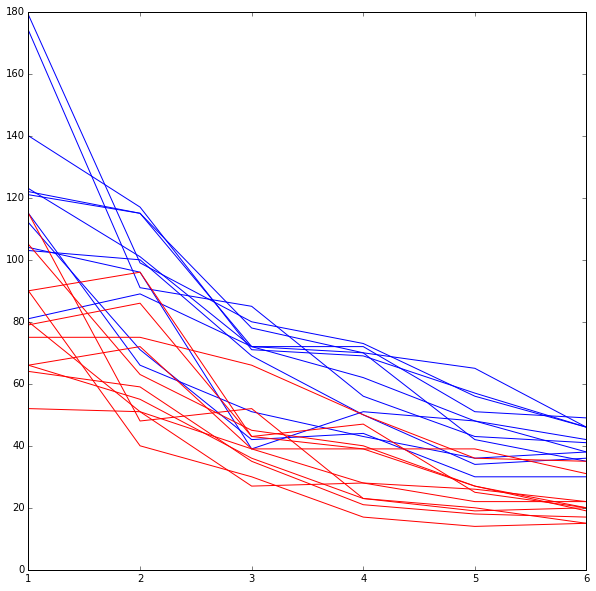

In [193]:
#look at specific tangram if desirable
test3 = test2.copy()
#test3 = test3[test3.tangram == "A"]


#groupby tangram and roundNum
wordNums = test3.groupby(['tangram', 'roundNum']).sum()


#PLOT NN parts of speech

pork_NN_A = wordNums.loc['A': 'A', 'NNnum': 'NNnum']
df_NN_A = pork_NN_A['NNnum'].tolist()

pork_NN_B = wordNums.loc['B': 'B', 'NNnum': 'NNnum']
df_NN_B = pork_NN_B['NNnum'].tolist()

pork_NN_C = wordNums.loc['C': 'C', 'NNnum': 'NNnum']
df_NN_C = pork_NN_C['NNnum'].tolist()

pork_NN_D = wordNums.loc['D': 'D', 'NNnum': 'NNnum']
df_NN_D = pork_NN_D['NNnum'].tolist()

pork_NN_E = wordNums.loc['E': 'E', 'NNnum': 'NNnum']
df_NN_E = pork_NN_E['NNnum'].tolist()

pork_NN_F = wordNums.loc['F': 'F', 'NNnum': 'NNnum']
df_NN_F = pork_NN_F['NNnum'].tolist()

pork_NN_G = wordNums.loc['G': 'G', 'NNnum': 'NNnum']
df_NN_G = pork_NN_G['NNnum'].tolist()

pork_NN_H = wordNums.loc['H': 'H', 'NNnum': 'NNnum']
df_NN_H = pork_NN_H['NNnum'].tolist()

pork_NN_I = wordNums.loc['I': 'I', 'NNnum': 'NNnum']
df_NN_I = pork_NN_I['NNnum'].tolist()

pork_NN_J = wordNums.loc['J': 'J', 'NNnum': 'NNnum']
df_NN_J = pork_NN_J['NNnum'].tolist()

pork_NN_K = wordNums.loc['K': 'K', 'NNnum': 'NNnum']
df_NN_K = pork_NN_K['NNnum'].tolist()

pork_NN_L = wordNums.loc['L': 'L', 'NNnum': 'NNnum']
df_NN_L = pork_NN_L['NNnum'].tolist()

#plotting NN
fig = plt.figure(figsize=(10, 10), dpi=100)
rounds = [1,2,3,4,5,6]
NN_A = df_NN_A
NN_B = df_NN_B
NN_C = df_NN_C
NN_D = df_NN_D
NN_E = df_NN_E
NN_F = df_NN_F
NN_G = df_NN_G
NN_H = df_NN_H
NN_I = df_NN_I
NN_J = df_NN_J
NN_K = df_NN_K
NN_L = df_NN_L

plt.plot(rounds, NN_A, color='blue')
plt.plot(rounds, NN_B, color='blue')
plt.plot(rounds, NN_C, color='blue')
plt.plot(rounds, NN_D, color='blue')
plt.plot(rounds, NN_E, color='blue')
plt.plot(rounds, NN_F, color='blue')
plt.plot(rounds, NN_G, color='blue')
plt.plot(rounds, NN_H, color='blue')
plt.plot(rounds, NN_I, color='blue')
plt.plot(rounds, NN_J, color='blue')
plt.plot(rounds, NN_K, color='blue')


#PLOTTING VB

pork_VB_A = wordNums.loc['A': 'A', 'VBnum': 'VBnum']
df_VB_A = pork_VB_A['VBnum'].tolist()

pork_VB_B = wordNums.loc['B': 'B', 'VBnum': 'VBnum']
df_VB_B = pork_VB_B['VBnum'].tolist()

pork_VB_C = wordNums.loc['C': 'C', 'VBnum': 'VBnum']
df_VB_C = pork_VB_C['VBnum'].tolist()

pork_VB_D = wordNums.loc['D': 'D', 'VBnum': 'VBnum']
df_VB_D = pork_VB_D['VBnum'].tolist()

pork_VB_E = wordNums.loc['E': 'E', 'VBnum': 'VBnum']
df_VB_E = pork_VB_E['VBnum'].tolist()

pork_VB_F = wordNums.loc['F': 'F', 'VBnum': 'VBnum']
df_VB_F = pork_VB_F['VBnum'].tolist()

pork_VB_G = wordNums.loc['G': 'G', 'VBnum': 'VBnum']
df_VB_G = pork_VB_G['VBnum'].tolist()

pork_VB_H = wordNums.loc['H': 'H', 'VBnum': 'VBnum']
df_VB_H = pork_VB_H['VBnum'].tolist()

pork_VB_I = wordNums.loc['I': 'I', 'VBnum': 'VBnum']
df_VB_I = pork_VB_I['VBnum'].tolist()

pork_VB_J = wordNums.loc['J': 'J', 'VBnum': 'VBnum']
df_VB_J = pork_VB_J['VBnum'].tolist()

pork_VB_K = wordNums.loc['K': 'K', 'VBnum': 'VBnum']
df_VB_K = pork_VB_K['VBnum'].tolist()

pork_VB_L = wordNums.loc['L': 'L', 'VBnum': 'VBnum']
df_VB_L = pork_VB_L['VBnum'].tolist()

#plotting
#fig = plt.figure(figsize=(10, 10), dpi=100)
rounds = [1,2,3,4,5,6]
VB_A = df_VB_A
VB_B = df_VB_B
VB_C = df_VB_C
VB_D = df_VB_D
VB_E = df_VB_E
VB_F = df_VB_F
VB_G = df_VB_G
VB_H = df_VB_H
VB_I = df_VB_I
VB_J = df_VB_J
VB_K = df_VB_K
VB_L = df_VB_L

plt.plot(rounds, VB_A, color='red')
plt.plot(rounds, VB_B, color='red')
plt.plot(rounds, VB_C, color='red')
plt.plot(rounds, VB_D, color='red')
plt.plot(rounds, VB_E, color='red')
plt.plot(rounds, VB_F, color='red')
plt.plot(rounds, VB_G, color='red')
plt.plot(rounds, VB_H, color='red')
plt.plot(rounds, VB_I, color='red')
plt.plot(rounds, VB_J, color='red')
plt.plot(rounds, VB_K, color='red')


#Graphing POS/totalWords

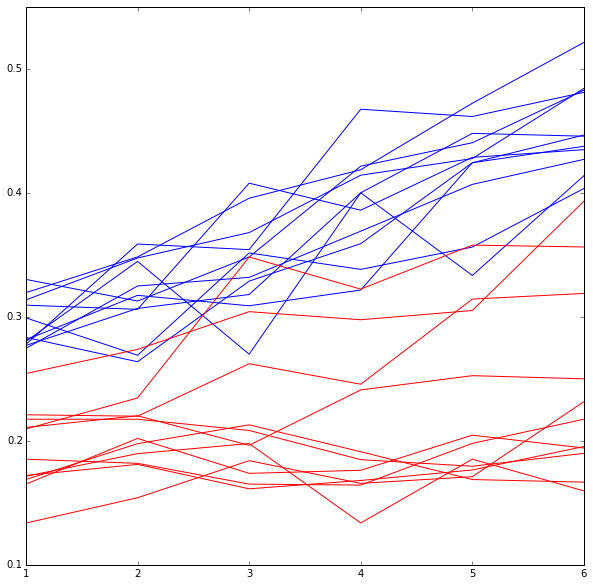

In [198]:
wordNums2 = wordNums.copy()
#calculate ratio of NN POS/total numWords
wordNums2['NNnumRat'] = wordNums2['NNnum']/wordNums2['numWords']
#calculate ratio of VB POS/total numWords
wordNums2['VBnumRat'] = wordNums2['VBnum']/wordNums2['numWords']

#RENAMING
#to make my life easier...so I can copy and past above code, I am changing the column names 
#NNnum will become NNraw and VBnum will become VBraw
wordNums2=wordNums2.rename(columns = {'NNnum':'NNraw'})
wordNums2=wordNums2.rename(columns = {'VBnum':'VBraw'})

#NNnumRat will be NNnum and VBnumRat will be VBnum
wordNums2=wordNums2.rename(columns = {'NNnumRat':'NNnum'})
wordNums2=wordNums2.rename(columns = {'VBnumRat':'VBnum'})

#now, I'm pulling the code from above to graph the ratio of NNnum and VBnum over rounds 1-6

#PLOT NN parts of speech

pork_NN_A = wordNums2.loc['A': 'A', 'NNnum': 'NNnum']
df_NN_A = pork_NN_A['NNnum'].tolist()

pork_NN_B = wordNums2.loc['B': 'B', 'NNnum': 'NNnum']
df_NN_B = pork_NN_B['NNnum'].tolist()

pork_NN_C = wordNums2.loc['C': 'C', 'NNnum': 'NNnum']
df_NN_C = pork_NN_C['NNnum'].tolist()

pork_NN_D = wordNums2.loc['D': 'D', 'NNnum': 'NNnum']
df_NN_D = pork_NN_D['NNnum'].tolist()

pork_NN_E = wordNums2.loc['E': 'E', 'NNnum': 'NNnum']
df_NN_E = pork_NN_E['NNnum'].tolist()

pork_NN_F = wordNums2.loc['F': 'F', 'NNnum': 'NNnum']
df_NN_F = pork_NN_F['NNnum'].tolist()

pork_NN_G = wordNums2.loc['G': 'G', 'NNnum': 'NNnum']
df_NN_G = pork_NN_G['NNnum'].tolist()

pork_NN_H = wordNums2.loc['H': 'H', 'NNnum': 'NNnum']
df_NN_H = pork_NN_H['NNnum'].tolist()

pork_NN_I = wordNums2.loc['I': 'I', 'NNnum': 'NNnum']
df_NN_I = pork_NN_I['NNnum'].tolist()

pork_NN_J = wordNums2.loc['J': 'J', 'NNnum': 'NNnum']
df_NN_J = pork_NN_J['NNnum'].tolist()

pork_NN_K = wordNums2.loc['K': 'K', 'NNnum': 'NNnum']
df_NN_K = pork_NN_K['NNnum'].tolist()

pork_NN_L = wordNums2.loc['L': 'L', 'NNnum': 'NNnum']
df_NN_L = pork_NN_L['NNnum'].tolist()

#plotting NN
fig = plt.figure(figsize=(10, 10), dpi=100)
rounds = [1,2,3,4,5,6]
NN_A = df_NN_A
NN_B = df_NN_B
NN_C = df_NN_C
NN_D = df_NN_D
NN_E = df_NN_E
NN_F = df_NN_F
NN_G = df_NN_G
NN_H = df_NN_H
NN_I = df_NN_I
NN_J = df_NN_J
NN_K = df_NN_K
NN_L = df_NN_L

plt.plot(rounds, NN_A, color='blue')
plt.plot(rounds, NN_B, color='blue')
plt.plot(rounds, NN_C, color='blue')
plt.plot(rounds, NN_D, color='blue')
plt.plot(rounds, NN_E, color='blue')
plt.plot(rounds, NN_F, color='blue')
plt.plot(rounds, NN_G, color='blue')
plt.plot(rounds, NN_H, color='blue')
plt.plot(rounds, NN_I, color='blue')
plt.plot(rounds, NN_J, color='blue')
plt.plot(rounds, NN_K, color='blue')


#PLOTTING VB

pork_VB_A = wordNums2.loc['A': 'A', 'VBnum': 'VBnum']
df_VB_A = pork_VB_A['VBnum'].tolist()

pork_VB_B = wordNums2.loc['B': 'B', 'VBnum': 'VBnum']
df_VB_B = pork_VB_B['VBnum'].tolist()

pork_VB_C = wordNums2.loc['C': 'C', 'VBnum': 'VBnum']
df_VB_C = pork_VB_C['VBnum'].tolist()

pork_VB_D = wordNums2.loc['D': 'D', 'VBnum': 'VBnum']
df_VB_D = pork_VB_D['VBnum'].tolist()

pork_VB_E = wordNums2.loc['E': 'E', 'VBnum': 'VBnum']
df_VB_E = pork_VB_E['VBnum'].tolist()

pork_VB_F = wordNums2.loc['F': 'F', 'VBnum': 'VBnum']
df_VB_F = pork_VB_F['VBnum'].tolist()

pork_VB_G = wordNums2.loc['G': 'G', 'VBnum': 'VBnum']
df_VB_G = pork_VB_G['VBnum'].tolist()

pork_VB_H = wordNums2.loc['H': 'H', 'VBnum': 'VBnum']
df_VB_H = pork_VB_H['VBnum'].tolist()

pork_VB_I = wordNums2.loc['I': 'I', 'VBnum': 'VBnum']
df_VB_I = pork_VB_I['VBnum'].tolist()

pork_VB_J = wordNums2.loc['J': 'J', 'VBnum': 'VBnum']
df_VB_J = pork_VB_J['VBnum'].tolist()

pork_VB_K = wordNums2.loc['K': 'K', 'VBnum': 'VBnum']
df_VB_K = pork_VB_K['VBnum'].tolist()

pork_VB_L = wordNums2.loc['L': 'L', 'VBnum': 'VBnum']
df_VB_L = pork_VB_L['VBnum'].tolist()

#plotting
#fig = plt.figure(figsize=(10, 10), dpi=100)
rounds = [1,2,3,4,5,6]
VB_A = df_VB_A
VB_B = df_VB_B
VB_C = df_VB_C
VB_D = df_VB_D
VB_E = df_VB_E
VB_F = df_VB_F
VB_G = df_VB_G
VB_H = df_VB_H
VB_I = df_VB_I
VB_J = df_VB_J
VB_K = df_VB_K
VB_L = df_VB_L

plt.plot(rounds, VB_A, color='red')
plt.plot(rounds, VB_B, color='red')
plt.plot(rounds, VB_C, color='red')
plt.plot(rounds, VB_D, color='red')
plt.plot(rounds, VB_E, color='red')
plt.plot(rounds, VB_F, color='red')
plt.plot(rounds, VB_G, color='red')
plt.plot(rounds, VB_H, color='red')
plt.plot(rounds, VB_I, color='red')
plt.plot(rounds, VB_J, color='red')
plt.plot(rounds, VB_K, color='red')



#Testing word count function

In [6]:
text = {'NN': [('guy', 1), ('hi', 13)], 'NNS': [('arms', 1)]}
text.values()[1][1][1]
list1 = [('guy', 1), ('hi', 1), ('yoyo', 20)]

#counts up the numbers associated with each word in a list
def total(l):
    count = 0
    length = len(l)
    for i in range(0,length):
        num = l[i][1]
        print num
        count += num
        #print count
    else: 
        return count
#count up the numbers associated with each word in list of lists (need .values() for dict)
def totalAll(l):
    count = 0
    length = len(l)
    for i in range(0,length):
        num = total(l[i])
        count += num
    else:
        return count
    
#totalAll(text.values())

#text.values()[1][1][0]

In [7]:
pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

#given a tag (like NN) find all the words tagged with that and their frequency
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text
                                  if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(5)) for tag in cfd.conditions())

#tokenize contents and look at one tangram at a time and groupby gameid, tangram, roundNum, contents
test1['tokens'] = [[word for word in nltk.word_tokenize(sentence.lower()) if word.isalpha()] for sentence in test1['contents']]
test2 = test1.copy()
del test2['time']

#tag part of speech for each token
test2['pos'] = [nltk.pos_tag(rowTokens) for rowTokens in test2['tokens']]


for g in ['1903-d']:
    for i in ['1', '2', '3', '4', '5', '6']:
        for t in ['A']:
            test2 = test2[(test2.tangram == t) & (test2.gameid == g) & (test2.roundNum == i)]
            #test2.groupby(['gameid', 'tangram', 'roundNum', 'contents']).sum()
            #print(test2)

            #create part of speech column
            test2['pos'] = [nltk.pos_tag(rowTokens) for rowTokens in test2['tokens']]

            tags = test2['pos']
            #turn tags from series into list and flatten
            tags.tolist()
            tagsFlat = [item for sublist in tags for item in sublist]
            #tagsFlat

            #look at frequency of parts of speech 
            tags_fd = nltk.FreqDist(tag for (word, tag) in tagsFlat)
            tags_fd.most_common()

            #locate all words tagged with NN and display their frequency
            tagdictVB = findtags('VB', tagsFlat)
            tagdictNN = findtags('NN', tagsFlat)
            

            #for tag in sorted(tagdict): print(tag, tagdict[tag])
            #print(g, i, t, tagdictVB)
            #print(g, i, t, tagdictNN)
            print(tagsFlat)

    
else:
    print("All done!")


#CC, VB, DT, NN, CD


height has been deprecated.

[('and', 'CC'), ('is', 'VBZ'), ('or', 'CC'), ('a', 'DT'), ('rabbit', 'NN'), ('is', 'VBZ'), ('the', 'DT'), ('one', 'CD'), ('kicking', 'VBG')]
[]
[]
[]
[]
[]
All done!


#Plotting word frequency distribution 

In [10]:
merged = pd.read_csv('/Users/nickimaslan/Desktop/convention_project/tangrams_replication/data/annotated_names/merged.csv')
merged.drop(['gameid','time'], axis=1)
from itertools import chain
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def tokenize(listOfStrings):
    mergedStr = []
    for wordStr in listOfStrings :   
        potato = nltk.word_tokenize(wordStr)
        mergedStr.append(potato)
    flat = [item for sublist in mergedStr for item in sublist]
    return flat
#     return list(chain.from_iterable(mergedStr))

def tangram(merged, tangram, roundNum ):   ##select tangram and round you want to look at
    merged.drop(['gameid','time'], axis=1)
    tanMerged = merged[merged['tangram'] == tangram]
    tanRound = tanMerged[tanMerged['roundNum'] == roundNum]
    return tanRound

def tokTan(dataframe):       ##will tokenize the contents grouped by roundNum
    wordsCountedC1 = dataframe.groupby(['roundNum'])['contents'].aggregate(tokenize)
    return wordsCountedC1

def cleanup(listofStrings):  ##only will do one list at a time
    listofStrings = [w for w in listofStrings if w not in stopwords]
    listofStrings = [w for w in listofStrings if w.isalpha()]
    listofStrings = [w for w in listofStrings if len(w) > 2]
    listofStrings = [w.lower() for w in listofStrings if w.isalpha()] 
    listofStrings = [w for w in listofStrings if w not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'the', 'like', 'either' 'ready', 'yeah' 'really,' 'ok', 'looks', 'okay', 'one', 'got', 'go']]
    return listofStrings

##example with tangram C on round1
tangramCr1 = tangram(merged, 'C', '1')
tokCr1 = tokTan(tangramCr1)
cleanCr1 = cleanup(tokCr1[0])
cleanCr1

##plot the frequency distribution

wordsCounted = merged.groupby(['roundNum'])['contents'].aggregate(tokenize)    #list of words in each round
cleaned1 = cleanup(wordsCounted[0])  # cleaned up list of words in round1
cleaned2 = cleanup(wordsCounted[1])
cleaned3 = cleanup(wordsCounted[2])
cleaned4 = cleanup(wordsCounted[3])
cleaned5 = cleanup(wordsCounted[4])
cleaned6 = cleanup(wordsCounted[5])

c = 0
while c < 6:
    cleanWords = cleanup(wordsCounted[c])
    c = c + 1

#cleanWords
#cleaned2

#wordsCounted
#fdist1 = nltk.FreqDist(cleaned)
#fdist1.plot(30, cumulative=False)





#  Tangram C vs G graph

[18.0, 12.0, 5.0, 6.0, 4.0, 4.0]
[31.0, 13.0, 16.0, 7.0, 5.0, 5.0]
[18.0, 12.0, 5.0, 6.0, 4.0, 4.0]
[31.0, 13.0, 16.0, 7.0, 5.0, 5.0]


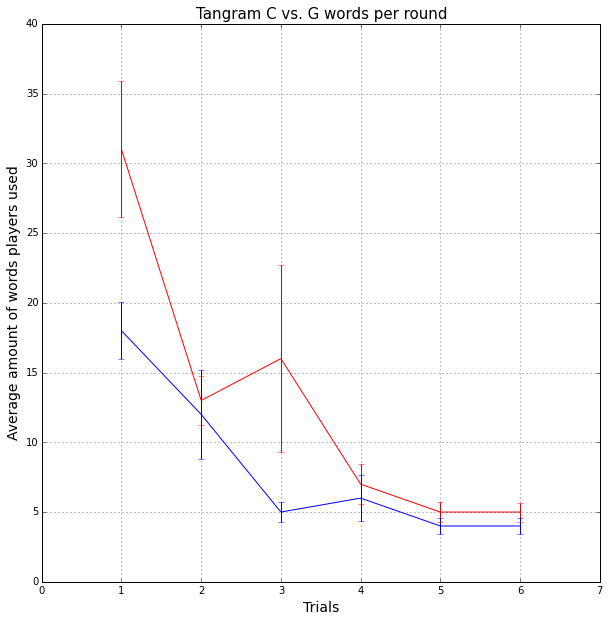

In [5]:
merged = pd.read_csv('/Users/nickimaslan/Desktop/convention_project/tangrams_replication/data/annotated_names/merged.csv')
from itertools import chain
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def countWords(listOfStrings):
    wordCount = 0
    for wordStr in listOfStrings :   
        potato = nltk.word_tokenize(wordStr) # tokenize it (returns a list of words)
        cleanPotato = cleanup(potato)
        length = len(potato)   # get length of token list
        wordCount = wordCount + length # add that number to wordCount
    return wordCount

def cleanup(aStr) :
    listofStrings = [w for w in aStr if w not in stopwords]
    listofStrings = [w for w in listofStrings if w.isalpha()]
    listofStrings = [w for w in listofStrings if len(w) > 2]
    listofStrings = [w.lower() for w in listofStrings if w.isalpha()] 
    listofStrings = [w for w in listofStrings if w not in ['like', 'either' 'ready', 'yeah' 'really,' 'ok', 'looks', 'okay', 'one', 'got', 'go']]
    return listofStrings

tanC = merged[merged['tangram'] == 'C']
tanG = merged[merged['tangram'] == 'G']

def getMean(dataframe):
    meanList = []
    for roundNumber in [1,2,3,4,5,6] :
        mergeByRound = dataframe[dataframe['roundNum'] == '%d' %roundNumber]
        wordsCounted = mergeByRound.groupby(['roundNum'])['contents'].aggregate(countWords)
        wordsPerRound = wordsCounted.apply(lambda x: x/(24))
        wordMean = wordsPerRound.mean()
        meanList.append(wordMean)
    return meanList

print(getMean(tanC))
print(getMean(tanG))
# print(tanC)
# print(tanG)



def getStDev(dataframe):
    stdList = []
    for roundNumber in [1,2,3,4,5,6] :
        mergeByRound = dataframe[dataframe['roundNum'] == '%d' %roundNumber]
        wordsCounted = mergeByRound.groupby(['roundNum','gameid'])['contents'].aggregate(countWords)
        wordsPerRound = wordsCounted.apply(lambda x: x/(1))
        std = wordsPerRound.std()
        stdList.append(std)
    return stdList



##df for tangram C
tanC = merged[merged['tangram'] == 'C']
wordsCountedC = tanC.groupby(['roundNum','gameid'])['contents'].aggregate(countWords)
meanC = getMean(tanC)
stErrorC = getStDev(tanC)/np.sqrt(24)
print(meanC)

%matplotlib inline


# ##df for tangram G
tanG = merged[merged['tangram'] == 'G']
wordsCountedG = tanG.groupby(['roundNum', 'gameid'])['contents'].aggregate(countWords)
meanG = getMean(tanG)
stErrorG = getStDev(tanG)/np.sqrt(24)
stErrorG
print(meanG)

##plot it
##data to be plotted
# wordsPerRound = wordsCounted.apply(lambda x: x/(12*24))
rounds = [1,2,3,4,5,6]

##error data

fig = plt.figure(figsize=(10, 10), dpi=100)

##plotting
# fig = plt.figure(figsize=(6, 6))
# axes = fig.add_subplot(111)
plt.plot(rounds, meanG, color='red')
plt.plot(rounds, meanC, color='blue')
# 
##plot error bars
plt.errorbar(rounds,meanG,yerr=stErrorG, linestyle="None", color="red")
plt.errorbar(rounds,meanC,yerr=stErrorC, linestyle="None", color="blue")




#configure x and y axes
plt.ylim([0,40])
plt.xlim([0,7])
plt.title('Tangram C vs. G words per round', size=15)
plt.grid(True)
plt.xlabel('Trials', size=14)
plt.ylabel('Average amount of words players used', size=14)

##save plot
plt.savefig("/Users/nickimaslan/Desktop/GvsCTangrams.png", bbox_inches='tight')

##show plot
plt.show()


# Avg Director word count for each tangram


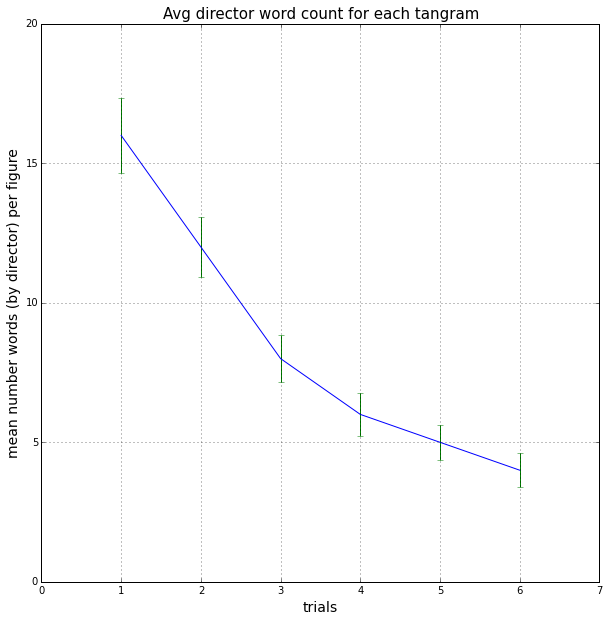

In [564]:
merged = pd.read_csv('/Users/nickimaslan/Desktop/convention_project/tangrams_replication/data/annotated_names/merged.csv')
from itertools import chain
def countWords(listOfStrings):
    wordCount = 0
    for wordStr in listOfStrings :   
        potato = nltk.word_tokenize(wordStr) # tokenize it (returns a list of words)
        length = len(potato)   # get length of token list
        wordCount = wordCount + length # add that number to wordCount
    return wordCount
        
# merged.groupby(['tangram'])['roundNum'].apply(plus1)
merged = merged[merged['sender'] == 'director']
merged = merged[merged['tangram'] != '0']
merged = merged[merged['tangram'] != '10']
merged = merged[merged['tangram'] != ':']

def getStDev(dataframe):
    stdList = []
    for roundNumber in [1,2,3,4,5,6] :
        mergeByRound = merged[merged['roundNum'] == '%d' %roundNumber]
        wordsCounted = mergeByRound.groupby(['roundNum','gameid'])['contents'].aggregate(countWords)
        wordsPerRound = wordsCounted.apply(lambda x: x/(12))
        std = wordsPerRound.std()
        stdList.append(std)
    return stdList

error = np.sqrt(24)

%matplotlib inline

wordsCounted = merged.groupby(['roundNum'])['contents'].aggregate(countWords)

##data to be plotted
wordsPerRound = wordsCounted.apply(lambda x: x/(12*24))
rounds = [1,2,3,4,5,6]

##error data
stdErrorList = getStDev(merged)/error

fig = plt.figure(figsize=(10, 10), dpi=100)

##plotting
# fig = plt.figure(figsize=(6, 6))
# axes = fig.add_subplot(111)
plt.plot(rounds, wordsPerRound)

##plot error bars
plt.errorbar(rounds,wordsPerRound,yerr=stdList, linestyle="None", color="green")

#configure x and y axes
plt.ylim([0,20])
plt.xlim([0,7])
plt.title('Avg director word count for each tangram', size=15)
plt.grid(True)
plt.xlabel('trials', size=14)
plt.ylabel('mean number words (by director) per figure', size=14)

##save plot
plt.savefig("/Users/nickimaslan/Desktop/avgWordsTallFont.png", bbox_inches='tight')

##show plot
plt.show()


In [4]:
merged = pd.read_csv('/Users/nickimaslan/Desktop/convention_project/tangrams_replication/data/annotated_names/merged.csv')
# merged.ix[0:, ['contents', 'tangram']]
tangramMerge = merged[merged['tangram'] != '0']
tangram = merged[merged['tangram'] == 'G']
tangramRound = tangram[tangram['roundNum'] == '6']
contents = tangramRound.ix[0:, ['contents']]
contents



,contents
135,1: the yoga dude
391,7 hippo
392,k
567,10 lounging rabbit
676,10 dancing women
836,triangle man
981,mostly rectangle on left and 2 triangle edges ...
982,4
1212,slide-n-slide
1428,6 has large L on the bottom


#Score Test

In [44]:
score_test = pd.read_csv('/Users/nickimaslan/Desktop/convention_project/tangrams_replication/data/good_dropObj/0215-4.csv')
score1 = score_test[[' roundNum', ' score']]
#score_group = score1.groupby('roundNum')
score1

,roundNum,score
0,1,0
1,1,0
2,1,1
3,1,2
4,1,1
5,1,2
6,1,3
7,1,3
8,1,3
9,1,3
